In [1]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
def mkdir(path):
    if not os.path.exists(path):
        os.makedirs(path)

runPath = os.getcwd()

data_dir =runPath + '/data/'
mkdir(data_dir)

## train_dir
train_dir = data_dir + 'train/'
mkdir(train_dir)

## valid_dir
valid_dir = data_dir + 'valid/'
mkdir(valid_dir)

## doll_train
doll_dir = train_dir + 'doll/'
mkdir(doll_dir)

## doll_valid
doll_valid_dir = valid_dir + 'doll/'
mkdir(doll_valid_dir)

## blue_train
blue_dir = train_dir + 'blue/'
mkdir(blue_dir)

## blue_valid
blue_valid_dir = valid_dir + 'blue/'
mkdir(blue_valid_dir)

In [3]:
########################## Image Augmentation #################################
def img_transforms():
    train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
            rescale=1. / 255,
            rotation_range=50,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=False,
            fill_mode='nearest',
    )
    
    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(150, 150),
        batch_size=30,
        seed=1,
        shuffle=True,
        class_mode='categorical'
    )


    valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rescale=1. / 255,
    )

    valid_generator = valid_datagen.flow_from_directory(
        valid_dir,
        target_size=(150, 150),
        batch_size=30,
        seed=1,
        shuffle=False,
        class_mode="categorical"
    )
    return train_generator,valid_generator

train_generator,valid_generator = img_transforms()


Found 850 images belonging to 2 classes.
Found 213 images belonging to 2 classes.


In [4]:
############################# Complex Model ###################################
def cnn(width,height,depth,outputNum):

    model = tf.keras.models.Sequential([

        tf.keras.layers.Conv2D(filters=16, 
                            kernel_size=3, 
                            padding='same', 
                            activation='relu', 
                            input_shape=[width, height, depth]), 

        tf.keras.layers.MaxPool2D(pool_size=3, strides=(3,3),padding='same'),

        tf.keras.layers.Conv2D(filters=64, 
                            kernel_size=3, 
                            padding='same', 
                            activation='relu'), 

        tf.keras.layers.MaxPool2D(pool_size=5, strides=(3,3),padding='same'),

        tf.keras.layers.Conv2D(filters=32, 
                            kernel_size=2, 
                            padding='same', 
                            activation='relu'), 

        tf.keras.layers.MaxPool2D(pool_size=3, strides=(2,2),padding='same'),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(2048, activation='relu'),
        tf.keras.layers.Dropout(rate=0.2),
        tf.keras.layers.Dense(1024, activation='relu'),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(outputNum, activation='softmax')
    ])

    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    model.summary()
    return model

model = cnn(150,150,3,2)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 50, 50, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 50, 50, 64)        9280      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 17, 17, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 17, 17, 32)        8224      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 9, 9, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 2592)              0

In [5]:
modelPath = './model'
mkdir(modelPath)

output_model_file = os.path.join(modelPath,"DollvsBlue_weights.h5")

def plot_learning_curves(history, label, epochs, min_value, max_value):
    data = {}
    data[label] = history.history[label]
    data['val_' + label] = history.history['val_' + label]
    pd.DataFrame(data).plot(figsize=(8, 5))
    plt.grid(True)
    plt.axis([0, epochs, min_value, max_value])
    plt.show()


TRAIN_STEP = 20


callbacks = [
            tf.keras.callbacks.TensorBoard(modelPath),
            tf.keras.callbacks.ModelCheckpoint(output_model_file,
                                            save_best_only=True,
                                            save_weights_only=True),
            tf.keras.callbacks.EarlyStopping(patience=5, min_delta=1e-3)
        ]


history = model.fit(
        train_generator,
        epochs=TRAIN_STEP,
        validation_data = valid_generator,
        callbacks = callbacks
    )

Epoch 1/20
 1/29 [>.............................] - ETA: 0s - loss: 0.6911 - accuracy: 0.6000WARNING:tensorflow:From D:\Anaconda\envs\tensorflow\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
29/29 [==============================] - 13s 450ms/step - loss: 0.6855 - accuracy: 0.5835 - val_loss: 0.6427 - val_accuracy: 0.6573
Epoch 2/20
29/29 [==============================] - 13s 442ms/step - loss: 0.6302 - accuracy: 0.6388 - val_loss: 0.5992 - val_accuracy: 0.7465
Epoch 3/20
29/29 [==============================] - 13s 449ms/step - loss: 0.4931 - accuracy: 0.8082 - val_loss: 0.3726 - val_accuracy: 0.8310
Epoch 4/20
29/29 [==============================] - 13s 445ms/step - loss: 0.4921 - accuracy: 0.7776 - val_loss: 0.3535 - val_accuracy: 0.8592
Epoch 5/20
29/29 [==============================] - 13s 446ms

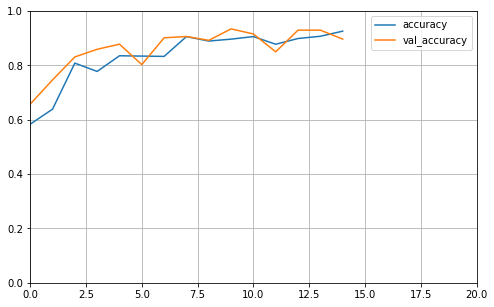

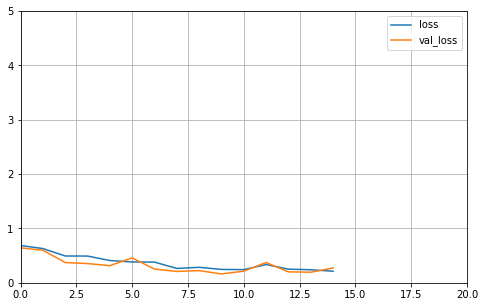

In [6]:
plot_learning_curves(history, 'accuracy', TRAIN_STEP, 0, 1)
plot_learning_curves(history, 'loss', TRAIN_STEP, 0, 5)

In [7]:
############################## Simple Model ###################################
def cnn(width,height,depth,outputNum):

    model = tf.keras.models.Sequential([

        tf.keras.layers.Conv2D(filters=16, 
                            kernel_size=5, 
                            padding='same', 
                            activation='relu', 
                            input_shape=[width, height, depth]), 

        tf.keras.layers.MaxPool2D(pool_size=5, strides=(5,5),padding='same'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(outputNum, activation='softmax')
    ])

    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    model.summary()
    return model

model = cnn(150,150,3,2)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 150, 150, 16)      1216      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 30, 30, 16)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 14400)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               1843328   
_________________________________________________________________
dense_7 (Dense)              (None, 2)                 258       
Total params: 1,844,802
Trainable params: 1,844,802
Non-trainable params: 0
_________________________________________________________________


In [8]:
output_model_file = os.path.join(modelPath,"DollvsBlue_weights_simple.h5")
history = model.fit(
        train_generator,
        epochs=TRAIN_STEP,
        validation_data = valid_generator,
        callbacks = callbacks
    )

Epoch 1/20
29/29 [==============================] - 12s 415ms/step - loss: 0.9203 - accuracy: 0.5094 - val_loss: 0.6622 - val_accuracy: 0.6620
Epoch 2/20
29/29 [==============================] - 11s 382ms/step - loss: 0.6807 - accuracy: 0.5741 - val_loss: 0.6284 - val_accuracy: 0.6573
Epoch 3/20
29/29 [==============================] - 11s 388ms/step - loss: 0.6761 - accuracy: 0.5894 - val_loss: 0.6371 - val_accuracy: 0.6667
Epoch 4/20
29/29 [==============================] - 11s 382ms/step - loss: 0.6570 - accuracy: 0.5953 - val_loss: 0.5822 - val_accuracy: 0.7324
Epoch 5/20
29/29 [==============================] - 11s 393ms/step - loss: 0.5547 - accuracy: 0.7376 - val_loss: 0.4661 - val_accuracy: 0.7887
Epoch 6/20
29/29 [==============================] - 11s 374ms/step - loss: 0.4343 - accuracy: 0.8118 - val_loss: 0.3333 - val_accuracy: 0.8592
Epoch 7/20
29/29 [==============================] - 11s 386ms/step - loss: 0.3596 - accuracy: 0.8506 - val_loss: 0.3040 - val_accuracy: 0.8685

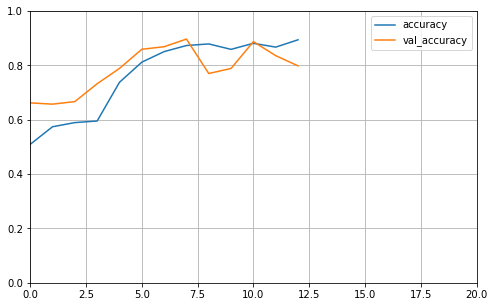

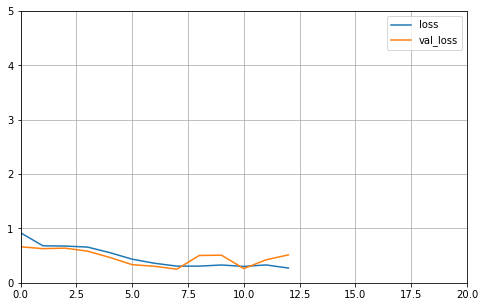

In [9]:
plot_learning_curves(history, 'accuracy', TRAIN_STEP, 0, 1)
plot_learning_curves(history, 'loss', TRAIN_STEP, 0, 5)